<a href="https://colab.research.google.com/github/laliali20/DSITwist2/blob/main/DSITwist2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytrends 

In [2]:
!pip install snscrape

In [3]:
!pip install pageviewapi

In [4]:

#%% Import modules
import datetime
import requests
import pandas as pd
from pytrends import dailydata
import snscrape.modules.twitter as sntwitter
import pageviewapi
import numpy as np
# import mysql.connector

#%% Define scraping functions
def get_google_trends_data(keyword, from_date, to_date):
    
    """
    Gets daily Google Trends for keyword.
    Dates like: 'YYYY-MM-DD'
    """
    
    from_year, from_month = datetime.date.fromisoformat(from_date).year, datetime.date.fromisoformat(from_date).month
    to_year, to_month = datetime.date.fromisoformat(to_date).year, datetime.date.fromisoformat(to_date).month

    data = dailydata.get_daily_data(keyword, from_year, from_month, to_year, to_month)
    
    return data[keyword]


def get_wikipedia_data(article, from_date, to_date):
    
    """
    Gets wikipedia article page views.
    Dates like: 'YYYYMMDD'
    """
    
    response =  pageviewapi.per_article('en.wikipedia.org', article, from_date, to_date,
                                        access = 'all-access', agent = 'all-agents', granularity = 'monthly')
    
    data = [x['views'] for x in response['items']]
    dates = [x['timestamp'] for x in response['items']]
    
    return pd.DataFrame({'date': dates, 'views': data})


# def get_twitter_data(keyword, from_date, to_date):
    
#     """
#     Gets twitter posts containing specific keyword.
#     Dates like: 'YYYY-MM-DD'
    
#     """
#     # Creating list to append tweet data to
#     counts_list = []
#     dates_list = []
    
#     days = pd.date_range(start = from_date, end = to_date)
    
#     for i in range(len(days)-1):
        
#         # Using TwitterSearchScraper to count daily tweets
#         daily_count = 0
#         for item in sntwitter.TwitterSearchScraper(keyword + ' since:' + str(days[i].date()) + ' until:' + str(days[i+1].date())).get_items():
#             daily_count = daily_count + 1
        
#         print("Day", str(days[i].date()), "had:", daily_count, ". Going to next day...")
        
#         dates_list.append(days[i].date())
#         counts_list.append(daily_count)
        
#     return pd.DataFrame({'date': dates_list, 'tweets': counts_list})
    

In [5]:

#%% Scrape desired data (might take a while)

# Get Google data and save them
google = get_google_trends_data('Kraken', '2019-10-01', '2022-02-28')
google.to_csv('google_data.csv')



Kraken:2019-10-01 2019-10-31
Kraken:2019-11-01 2019-11-30
Kraken:2019-12-01 2019-12-31
Kraken:2020-01-01 2020-01-31
Kraken:2020-02-01 2020-02-29
Kraken:2020-03-01 2020-03-31
Kraken:2020-04-01 2020-04-30
Kraken:2020-05-01 2020-05-31
Kraken:2020-06-01 2020-06-30
Kraken:2020-07-01 2020-07-31
Kraken:2020-08-01 2020-08-31
Kraken:2020-09-01 2020-09-30
Kraken:2020-10-01 2020-10-31
Kraken:2020-11-01 2020-11-30
Kraken:2020-12-01 2020-12-31
Kraken:2021-01-01 2021-01-31
Kraken:2021-02-01 2021-02-28
Kraken:2021-03-01 2021-03-31
Kraken:2021-04-01 2021-04-30
Kraken:2021-05-01 2021-05-31
Kraken:2021-06-01 2021-06-30
Kraken:2021-07-01 2021-07-31
Kraken:2021-08-01 2021-08-31
Kraken:2021-09-01 2021-09-30
Kraken:2021-10-01 2021-10-31
Kraken:2021-11-01 2021-11-30
Kraken:2021-12-01 2021-12-31
Kraken:2022-01-01 2022-01-31
Kraken:2022-02-01 2022-02-28


In [6]:
# Get Wikipedia data and save them
wikipedia = get_wikipedia_data('Kraken', '20191001', '20220228')
wikipedia.to_csv('wikipedia_data.csv')

In [7]:
# build db

import sqlite3
sqlite3.connect('db_dsi_twist')

conn = sqlite3.connect('db_dsi_twist') 
c = conn.cursor()

c.execute('''
          CREATE TABLE IF NOT EXISTS google
          (date date, mentions)
          ''')
          
c.execute('''
          CREATE TABLE IF NOT EXISTS wikipedia
          (dateid , mentions)
          ''')
                     
conn.commit()

In [8]:
from sqlalchemy import create_engine
dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')
df_google = pd.read_csv('/content/google_data.csv', sep = ',', parse_dates=['date'], date_parser=dateparse)
df_wiki = pd.read_csv('/content/wikipedia_data.csv', sep = ',')

df_google.to_sql('google_data',  conn, if_exists='replace', index=False)
df_wiki.to_sql('wiki_data',  conn, if_exists='replace', index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2882: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [9]:
google_query = '''
select * 
from google_data
'''

wiki_query = '''
select * 
from wiki_data
'''

df1 = pd.read_sql(google_query, conn )
df2 = pd.read_sql(wiki_query, conn)
df2

,Unnamed: 0,date,views
0,0,2019100100,66833
1,1,2019110100,65284
2,2,2019120100,61757
3,3,2020010100,89528
4,4,2020020100,65809
5,5,2020030100,62899
6,6,2020040100,73262
7,7,2020050100,74209
8,8,2020060100,76217
9,9,2020070100,420186


In [10]:
# forecast input
std_date = lambda x: str(str(x)[0:4]) + "-" + str(str(x)[4:6]) + "-01"
std_date2 = lambda x: str(str(x)[0:7]) + "-01"
df2['temp_date'] = df2['date'].apply(std_date)
df1['temp_date'] = df1['date'].apply(std_date2)
df1_in = df1.groupby('temp_date').agg({'Kraken':'sum'}).sort_values('temp_date').reset_index()
df2_in = df2.groupby('temp_date').agg({'views':'sum'}).sort_values('temp_date').reset_index()

In [11]:
holdout = len(df1_in) - 12
nobs_train = [i for i in range(0, holdout)]
nobs_test = [i for i in range(holdout, len(df1_in))]
train_goog = df1_in.iloc[nobs_train]
test_goog = df1_in.iloc[nobs_test]

In [12]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller


def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
adfuller_test(df1_in['Kraken'].to_list())

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9584
 No. Lags Chosen       = 0
 Critical value 1%     = -3.689
 Critical value 5%     = -2.972
 Critical value 10%    = -2.625
 => P-Value = 0.039. Rejecting Null Hypothesis.
 => Series is Stationary.


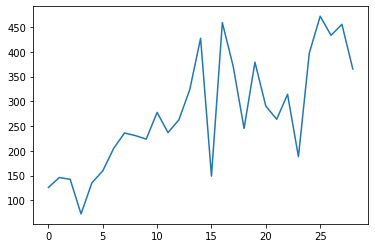

In [14]:
import matplotlib.pyplot as plt

plt.plot(df1_in['Kraken'])
plt.show()

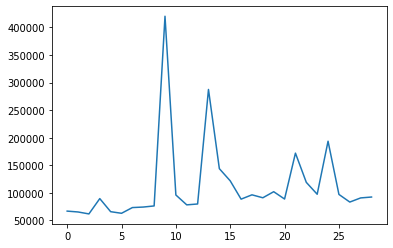

In [15]:
plt.plot(df2_in['views'])
plt.show()

In [16]:
adfuller_test(df2_in['views'].to_list())

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1743
 No. Lags Chosen       = 3
 Critical value 1%     = -3.724
 Critical value 5%     = -2.986
 Critical value 10%    = -2.633
 => P-Value = 0.2157. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [17]:
fit_goog_test = Holt(train_goog['Kraken']).fit(optimized=True)
fcast_goog_test = fit_goog_test.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [18]:
def compute_MAPE(act, fcast):
  err = np.zeros(len(act))
  for i in range(len(act)):
    err[i] = (abs(act[i] - fcast[i]))/act[i]
  return err.mean()

# Wikipedia views

In [20]:
holdout = len(df1_in) - 12
nobs_train = [i for i in range(0, holdout)]
nobs_test = [i for i in range(holdout, len(df1_in))]
train_wiki = df2_in.iloc[nobs_train]
test_wiki = df2_in.iloc[nobs_test]

In [21]:
fit_wiki = Holt(train_wiki['views']).fit(optimized=True)
fcast_wiki_test = fit_wiki.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


# Forecast (12 months ahead)

In [22]:
fit_goog = Holt(df1_in['Kraken']).fit(optimized=True)
fit_wiki = Holt(df2_in['views']).fit(optimized=True)
forecast_goog = fit_goog.forecast(12)
forecast_wiki = fit_wiki.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


# Dashboard prep

In [23]:
! pip install dash   
! pip install dash-html-components                                         
! pip install dash-core-components                                     
! pip install plotly

     |████████████████████████████████| 9.6 MB 3.2 MB/s 
     |████████████████████████████████| 357 kB 21.2 MB/s 


In [24]:
fcast_dates = ['2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01','2023-01-01','2023-02-01']

In [27]:
df1_out = pd.DataFrame({'date': fcast_dates, 'Kraken':  forecast_goog}) 
df2_out = pd.DataFrame({'date': fcast_dates, 'views':  forecast_wiki})

In [28]:
df2_out.to_sql('wiki_forecast',  conn, if_exists='replace', index=False)
df1_out.to_sql('goog_forecast',  conn, if_exists='replace', index=False)

In [29]:
df2_in.to_sql('wiki_input',  conn, if_exists='replace', index=False)
df1_in.to_sql('goog_input',  conn, if_exists='replace', index=False)

In [30]:
wiki_query = '''
SELECT * 
FROM wiki_input
union
SELECT * 
from wiki_forecast
'''

goog_query = '''
SELECT * 
FROM goog_input
union
SELECT * 
from goog_forecast
'''

wiki_fin = pd.read_sql(wiki_query, conn )
goog_fin = pd.read_sql(goog_query, conn )

In [32]:
wiki_fin.to_csv('wiki.csv')
goog_fin.to_csv('goog.csv')